In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words=open('names.txt','r').read().splitlines()
char=sorted(set(''.join(words))) 
stoi={s:(i+1) for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
block_size=3

In [4]:
def build_dataset(words):
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    xs=torch.tensor(x)    
    ys=torch.tensor(y)
    return xs,ys

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_dev,y_dev=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])

In [5]:
x_train.shape

torch.Size([182625, 3])

In [6]:
n_emb=10
n_hidden=200

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(vocab_size, n_emb, generator=g)
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)
b1=torch.randn(n_hidden, generator=g)
w2=torch.randn(n_hidden, vocab_size, generator=g)
b2=torch.randn(27, generator=g)*0

parameters=[c, w1, b1, w2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

11897


what happens if hpreact is near zero then tanh will map it to zero if it is high  tanh1 will squeeze it to 1 resulting in dead neurons which may not ever get activated during training

so one of the method is to make o/p follows input i.e hpreact follows same gussian standard deviation as that of embcat and it will cause product of two gussian ditribution results in annother gussian distrb. but the thing is distribution i.e hpreact will be more deviated from mean(0) in this case resulting in tanh to squeeze it to 1 in initialization phase or we can say std is nolonger 1 it scales up by some factor.So , to keep std 1 we make some changes to weights and biases of those activations neurons (in this case we alter w1 and b1).All this concern is for initialization because if we suceedd to initialize with best parameters then model will be actually being trained from early phase rather than squashing weights in early satges.

for the best initialization we ve sth called gain for activations which is sqrt(2) for relu and 5/3 for tanh.

for tanh it is std_n= gain/sqrt(fan_mode) 

where fan_mode is no of input to that layer containing activation i.e. 10 in this case

what it means is  torch.randn(1000) has mean 0 and std 1 if we multiply it with that value equal to std given by formula then std of our input distrib is going to be std_n
 


In [5]:
torch.randn(1000).std()

tensor(1.0136)

In [6]:
(torch.randn(1000)*0.2).std()

tensor(0.2044)

now what it does it it makes the hpreact to be more standard normally distributed such that tanh will not squeeze most  neuron to 1 in early phase

but doing this is abit tedious is not used anymore due to advanced concepts like batch normalization,layer normalization ,adam optimizer,rmsprop and so on


In [23]:
(5/3)/(30**0.5)

0.3042903097250923

In [26]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    break



      0/ 200000	24.807701


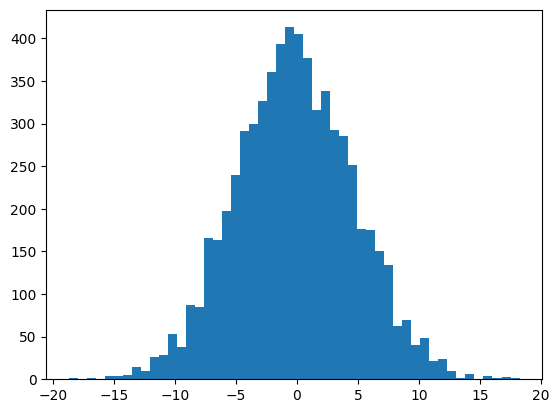

In [27]:
plt.hist(hpreact.view(-1).tolist(),50);

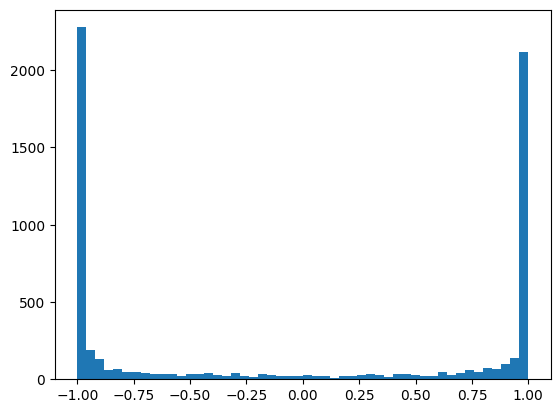

In [28]:
plt.hist(hp.view(-1).tolist(),50);

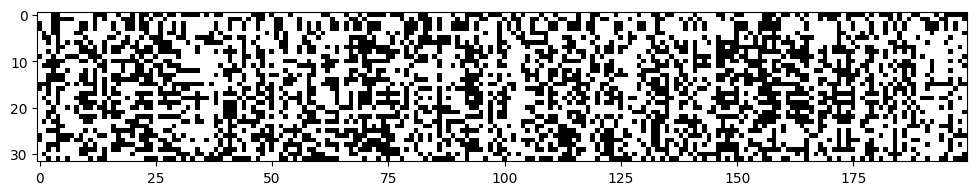

In [29]:
plt.figure(figsize=(12,6))
plt.imshow(hp.abs()>0.99,cmap='grey',interpolation='nearest')

In [41]:
# this code is right and is just a showcase for above mentioned description


n_emb=10
n_hidden=200

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(vocab_size, n_emb, generator=g)
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)*0.3042903
b1=torch.randn(n_hidden, generator=g)*0.01
w2=torch.randn(n_hidden, vocab_size, generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[c, w1, b1, w2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

11897


In [42]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    break



      0/ 200000	3.275305


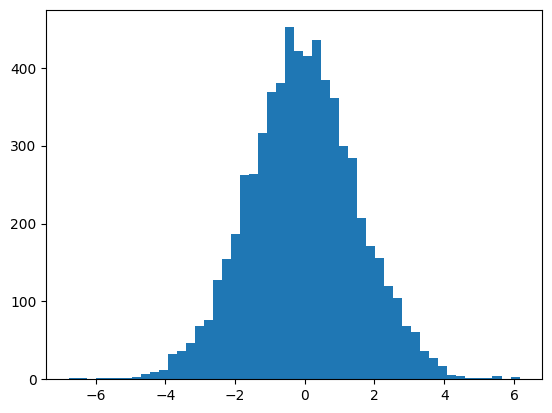

In [43]:
plt.hist(hpreact.view(-1).tolist(),50);

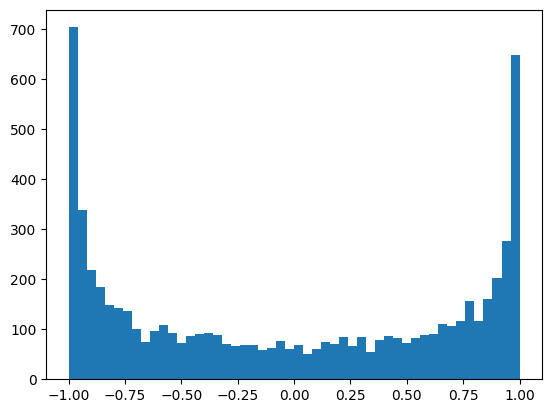

In [44]:
plt.hist(hp.view(-1).tolist(),50);

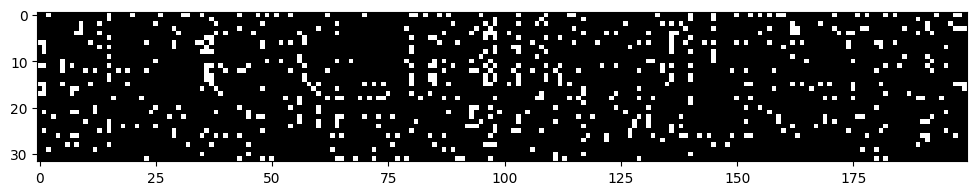

In [45]:
plt.figure(figsize=(12,6))
plt.imshow(hp.abs()>0.99,cmap='grey',interpolation='nearest')

In [46]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    # break



      0/ 200000	3.231836
  10000/ 200000	2.387108
  20000/ 200000	2.215286
  30000/ 200000	2.273314
  40000/ 200000	2.213061
  50000/ 200000	2.521004
  60000/ 200000	1.688165
  70000/ 200000	2.085647
  80000/ 200000	1.873310
  90000/ 200000	2.482720
 100000/ 200000	2.425395
 110000/ 200000	1.833260
 120000/ 200000	2.074562
 130000/ 200000	2.034273
 140000/ 200000	2.436685
 150000/ 200000	1.989608
 160000/ 200000	2.230251
 170000/ 200000	1.745228
 180000/ 200000	2.427426
 190000/ 200000	2.056065


In [47]:
@torch.no_grad
def split_loss(split):
    x,y={'train':(x_train,y_train),
        'dev':(x_dev,y_dev),
        'test':(x_test,y_test)}[split]           
    emb=c[x]
    h=torch.tanh(emb.view(emb.shape[0],-1)@w1+b1)
    logits=h@w2+b2
    loss=F.cross_entropy(logits,y)
    print(f'{split} {loss}')
split_loss('train')
split_loss('dev')


train 2.03971791267395
dev 2.106520175933838


In [48]:
g=torch.Generator().manual_seed(2146483147)
block_size=3
for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=c[torch.tensor(context)]
        h1=torch.tanh(emb.view(-1,30)@w1+b1)
        logits=h1@w2+b2
        prob=F.softmax(logits,dim=1)
        ix=torch.multinomial(prob,num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
        context=context[1:]+[ix]
    print(''.join(out))

ambran.
kahia.
kalia.
ardince.
blake.
jahsier.
issa.
mika.
chesha.
noutmferna.
godi.
kinding.
kyan.
adalandre.
dreia.
neila.
ren.
jadiz.
neyna.
nilah.


# so how does batch normalization works?
aba problem k thyo vnda malie standard normal distribution vayeko hpreact chaiyeko thyo kinaki starting phase ma 0 vnda jati divert vayo teti badi tanh ley teslie 1 ma sequeeze grca ani backprop ma tesko kei role aaudaina

aba paxi ko iterations ma tw aafno marzi ley jasari loss gathxa tesari nai weights update huney kunai less trigger kunai badi trigger huney nai vayo tara initial stage ja kei ni sikeko hunna teti bela randomly j paye initalize grerw training steps waste grnu vnda rmrari initilze grey full focus training and learning ma hunxa vanni concept ho

aba k ho tw vnda hmlie hidden layer j ma activation xa in this case tanh so we will be more talking about tanh tyo tanh funtion lie input standard gausssian distribution vayeko data dina pryo . tesko lagi kina tauko dukahuni hpreact lie nai normalie grdim natw aayo tanh lie gaussian distrb ko data squeezing reduced to 1 highly decreased 
yei ho batch normalization ko concept 


In [49]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [50]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

for each neuron for all 32 batches we calculated the mean and std so we can no apply normalization

we will want this normalized input for tanh in early stage only hence we add bngain and bnbias as shown in code below:


In [51]:
n_emb=10
n_hidden=200

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(vocab_size, n_emb, generator=g)
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)
b1=torch.randn(n_hidden, generator=g)
w2=torch.randn(n_hidden, vocab_size, generator=g)*0.01
b2=torch.randn(27, generator=g)*0

bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)

parameters=[c, w1, b1, w2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12297


In [52]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hpreact= bngain*((hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True))+bnbias
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    break



      0/ 200000	3.320909


since all batches are random ,randomnly batches lirako xa ni ani tyo random batches lie ek arko snga mathematical relationship (mean and std) ma use grerw logits nikalerw weights update garirako xa . Tesle noise obvioulsy  harek trainig ma add grxa or we can say jitter and model kailai ni overfit huna paunna so side effect regularization technique ko rup ma ni line sakinxa .

Due to randomly taken batches be binded in mathematical relationship and then being used for weights update many scientist dont recommend it and rather insist on using other normalization and regularization techniques


In [53]:
@torch.no_grad
def split_loss(split):
    x,y={'train':(x_train,y_train),
        'dev':(x_dev,y_dev),
        'test':(x_test,y_test)}[split]           
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hpreact= bngain*((hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True))+bnbias
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    print(f'{split} {loss}')
split_loss('train')
split_loss('dev')


train 3.273092746734619
dev 3.272266149520874


aba yesma 1 hidden layer matra vayerw khasai effect dekhayenw batch normalization ko, tara dherai hidden layers xan vnye very very impactful hunxa


# ...
inference ma herda or val and testing data ma herda hmle hpreact nikalna batches ko mean rw std khoji raxam

vneko testing and val phase ma input batches ma khojxa but hmle individual input ni dina milney gari banauna prxa so hmle xuttai training example ko mean rw std nikalaxm

In [54]:
with torch.no_grad():
    emb=c[x_train]
    hpreact=emb.view(emb.shape[0],-1)@w1+b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

now we use this mean and std in inference mode such that we can pass individual inputs

In [55]:
@torch.no_grad
def split_loss(split):
    x,y={'train':(x_train,y_train),
        'dev':(x_dev,y_dev),
        'test':(x_test,y_test)}[split]           
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hpreact= bngain*((hpreact-bnmean )/bnstd )+bnbias
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    print(f'{split} {loss}')
split_loss('train')
split_loss('dev')


train 3.273092746734619
dev 3.2722060680389404


but no one wants to calculate mean and std separately after whole training so what we do it is we proceed as follow by defining two parameters #bnmean# and #bnstd# and calculate its value during training 

In [71]:
n_emb=10
n_hidden=200

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(vocab_size, n_emb, generator=g)
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)
b1=torch.randn(n_hidden, generator=g)
w2=torch.randn(n_hidden, vocab_size, generator=g)*0.01
b2=torch.randn(27, generator=g)*0

bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)

bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)

parameters=[c, w1, b1, w2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12297


In [57]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact= bngain*((hpreact-bnmeani)/bnstdi)+bnbias

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running=0.999*bnstd_running + 0.001 * bnstdi

    
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    # break



      0/ 200000	3.311156
  10000/ 200000	1.835095
  20000/ 200000	2.373222
  30000/ 200000	2.396434
  40000/ 200000	2.001930
  50000/ 200000	1.735915
  60000/ 200000	2.232135
  70000/ 200000	2.188521
  80000/ 200000	2.269584
  90000/ 200000	2.151472
 100000/ 200000	2.319045
 110000/ 200000	2.258923
 120000/ 200000	1.856632
 130000/ 200000	2.190938
 140000/ 200000	1.868943
 150000/ 200000	2.078972
 160000/ 200000	2.372032
 170000/ 200000	2.281175
 180000/ 200000	2.389179
 190000/ 200000	2.683996


In [58]:
bnstd

tensor([[4.3932, 5.9141, 5.3887, 4.0556, 3.5153, 4.3729, 4.7710, 5.1025, 4.8627,
         5.2751, 4.1815, 4.3227, 3.9822, 5.0469, 3.7067, 5.8859, 4.6672, 4.4862,
         5.2521, 4.1639, 3.8200, 4.6246, 3.8319, 4.3295, 4.8110, 4.4912, 3.7347,
         4.1575, 4.4783, 4.8874, 3.6554, 4.8764, 4.4597, 4.7279, 3.8698, 6.2402,
         5.6841, 5.7306, 5.5160, 4.8001, 4.8806, 3.0298, 3.8435, 5.4697, 3.8989,
         5.3635, 4.5150, 4.2966, 5.4169, 5.1448, 4.5892, 4.0917, 5.3912, 4.1787,
         5.9760, 3.4748, 5.8513, 6.0169, 3.5542, 6.6469, 6.2973, 4.2763, 4.0158,
         4.9539, 6.1070, 4.3891, 3.6506, 3.8848, 4.5700, 4.9128, 4.4001, 3.1452,
         4.7074, 5.7100, 5.1969, 4.7480, 5.0495, 4.2066, 3.5537, 4.8524, 6.9432,
         4.8017, 2.9871, 4.6528, 5.3498, 5.4020, 3.8300, 5.3118, 5.0779, 5.9086,
         4.6914, 4.1379, 4.3568, 5.6007, 6.0160, 5.4651, 5.8218, 6.0259, 5.8081,
         3.6426, 4.9407, 4.4973, 5.0742, 6.1289, 3.8054, 4.4352, 5.1445, 5.3128,
         5.4079, 5.9169, 3.9

In [59]:
bnstd_running

tensor([[6.1767, 5.8856, 5.6289, 5.0939, 4.9488, 4.4404, 5.0591, 4.7976, 5.6743,
         6.4457, 6.2961, 5.2138, 4.3777, 4.9760, 3.9083, 5.7137, 4.6322, 4.9885,
         5.2927, 4.5877, 4.4219, 5.1999, 4.6205, 6.4444, 5.4247, 5.3288, 4.3923,
         4.6914, 5.2628, 5.2425, 4.1436, 5.2337, 4.9999, 4.9447, 4.1017, 6.0652,
         6.6025, 5.8999, 4.5476, 5.8266, 5.4462, 3.2067, 4.2791, 6.1754, 4.0761,
         5.8440, 5.3404, 4.2901, 5.9339, 5.0906, 5.2359, 5.3510, 5.6118, 4.6941,
         5.1033, 4.2676, 5.2051, 5.5240, 3.8373, 6.9335, 7.3847, 6.6744, 5.3990,
         4.8552, 6.2095, 5.2509, 3.6649, 4.7054, 5.2212, 5.7086, 4.6559, 4.0380,
         5.4395, 7.4206, 6.3235, 4.8784, 4.7220, 5.2239, 3.8678, 4.8123, 6.3640,
         4.9168, 3.6429, 4.7529, 6.2913, 6.2905, 3.9356, 4.3406, 5.6504, 5.9596,
         4.9386, 4.5407, 5.2169, 5.2237, 6.3360, 5.1296, 6.4245, 6.0876, 6.8622,
         4.2736, 5.2744, 5.1925, 5.3741, 6.2550, 4.3281, 4.5849, 6.4419, 5.4762,
         5.7564, 6.3564, 4.3

now we can use bnmean_running and bnstd_running w/o expilicitly calculating bnmean and bnstd

In [60]:
@torch.no_grad
def split_loss(split):
    x,y={'train':(x_train,y_train),
        'dev':(x_dev,y_dev),
        'test':(x_test,y_test)}[split]           
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=(embcat@w1+b1)
    hpreact= bngain*((hpreact-bnmean_running )/bnstd_running )+bnbias
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    print(f'{split} {loss}')
split_loss('train')
split_loss('dev')


train 2.1156623363494873
dev 2.1449649333953857


In batch noramlization bias b1 has shape 200 ie it is a row vector 

and b[0] is added to each and every element in batch and when mean is taken then bias cancels out ,hence to reduce the unnecessary computations  we often make bias false in case of batch normalization and the bias of batch normalization does the work of biases for neurons

# hence final code for batch noramlization becomes

In [291]:
n_emb=10
n_hidden=200

g=torch.Generator().manual_seed(2146483147)
c=torch.randn(vocab_size, n_emb, generator=g)
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)
# b1=torch.randn(n_hidden, generator=g)
w2=torch.randn(n_hidden, vocab_size, generator=g)*0.01
b2=torch.randn(27, generator=g)*0

bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)

bnmean_running=torch.zeros(1,n_hidden)
bnstd_running=torch.ones(1,n_hidden)

parameters=[c, w1, w2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12097


In [280]:
max_steps=200000
batch_size=32
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    x,y=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    
    #linear layer
    hpreact=(embcat@w1)

     #batch normalization
    #------------------------------------------------------------------------------------------------------------#
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact= bngain*((hpreact-bnmeani)/bnstdi)+bnbias

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running=0.999*bnstd_running + 0.001 * bnstdi
    #------------------------------------------------------------------------------------------------------------#
    
    hp=torch.tanh(hpreact)
    logits=hp@w2+b2
    loss=F.cross_entropy(logits,y)
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
        
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # print(loss.item())
    break



      0/ 200000	3.274576


In [11]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g)#/fan_in**0.5
        self.bias=torch.randn(fan_out) if bias else None

    def __call__(self,x):
        self.out=x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
        
    def parameters(self):
        return [self.weight]+([] if self.bias is None else [self.bias])

class batchNorm1D:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
n_emb=10
n_hidden=100
g=torch.Generator().manual_seed(2147483647)

c=torch.randn((vocab_size,n_emb),generator=g)

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

layers=[
    Linear(block_size*n_emb,n_hidden,bias=False),batchNorm1D(n_hidden),Tanh(),
    # Linear(           n_hidden,n_hidden,bias=False),batchNorm1D(n_hidden),Tanh(),
    # Linear(           n_hidden,n_hidden,bias=False),batchNorm1D(n_hidden),Tanh(),
    # Linear(           n_hidden,n_hidden,bias=False),batchNorm1D(n_hidden),Tanh(),
    # Linear(           n_hidden,n_hidden,bias=False),batchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,vocab_size,bias=False)#,batchNorm1D(vocab_size)
]
with torch.no_grad():
    layers[-1].weight*=0.1
    # layers[-1].gamma*=0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*= 1 #5/3

parameters=[c]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))#p.numel() is eqv p.nelement()
for p in parameters:
    p.requires_grad=True

6170


In [21]:
max_steps=200000
batch_size=32
up=[]
for i in range(max_steps):
    
    #creating batch
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    xb,yb=x_train[ix],y_train[ix]
    
    #forward pass
    emb=c[xb]
    x=emb.view(emb.shape[0],-1)

    for layer in layers:
        x=layer(x)
    #non-Linear layer
    loss=F.cross_entropy(x,yb)
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update weights
    lr=1#0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad

    
    with torch.no_grad():
        up.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    
    if i % 10000==0:
        print(f'{i:7d}/{max_steps:7d}\t{loss:4f}')
    # break
    # print(loss.item())
    # if i>=1000:
    #     break


      0/ 200000	3.461451
  10000/ 200000	2.843917
  20000/ 200000	2.747320
  30000/ 200000	2.824290
  40000/ 200000	2.596084
  50000/ 200000	2.461824
  60000/ 200000	2.576425
  70000/ 200000	2.307747
  80000/ 200000	2.513497
  90000/ 200000	2.375396
 100000/ 200000	2.145549
 110000/ 200000	2.070938
 120000/ 200000	2.448590
 130000/ 200000	2.207074
 140000/ 200000	2.159888
 150000/ 200000	2.036323
 160000/ 200000	2.283401
 170000/ 200000	2.280915
 180000/ 200000	2.441221
 190000/ 200000	2.209983


In [25]:
for layer in layers:
    layer.trainiable=False

In [28]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    xb,yb = {
        'train': (x_train, y_train),
        'val': (x_dev, y_dev),
        'test': (x_test, y_test),
      }[split]
    emb=c[xb]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss = F.cross_entropy(x, yb)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3105530738830566
val 2.3117806911468506


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.16%
layer 5 (      Tanh): mean -0.02, std 0.64, saturated: 3.38%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.94%
layer 11 (      Tanh): mean +0.01, std 0.64, saturated: 3.03%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.88%


Text(0.5, 1.0, 'activation distribution')

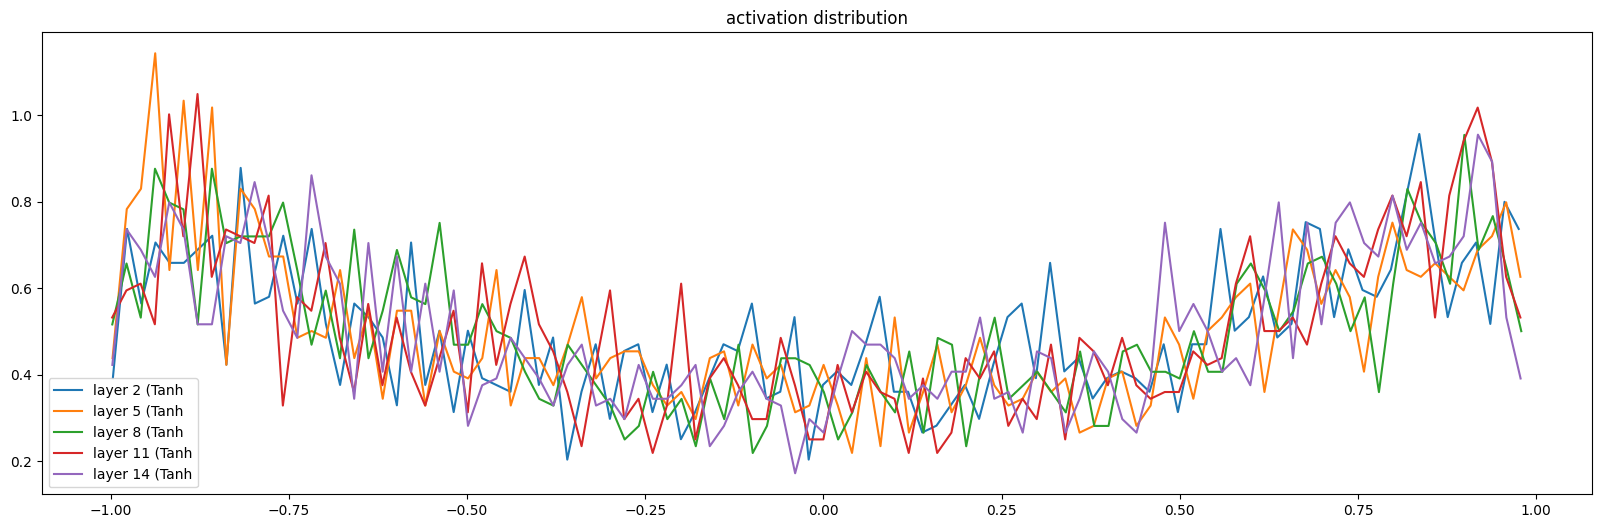

In [438]:
plt.figure(figsize=(20, 6)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2:Tanh, 	 mean:-0.000,	 std:0.004
layer 5:Tanh, 	 mean:-0.000,	 std:0.004
layer 8:Tanh, 	 mean:-0.000,	 std:0.003
layer 11:Tanh, 	 mean:0.000,	 std:0.003
layer 14:Tanh, 	 mean:-0.000,	 std:0.004


Text(0.5, 1.0, 'gradient distribution')

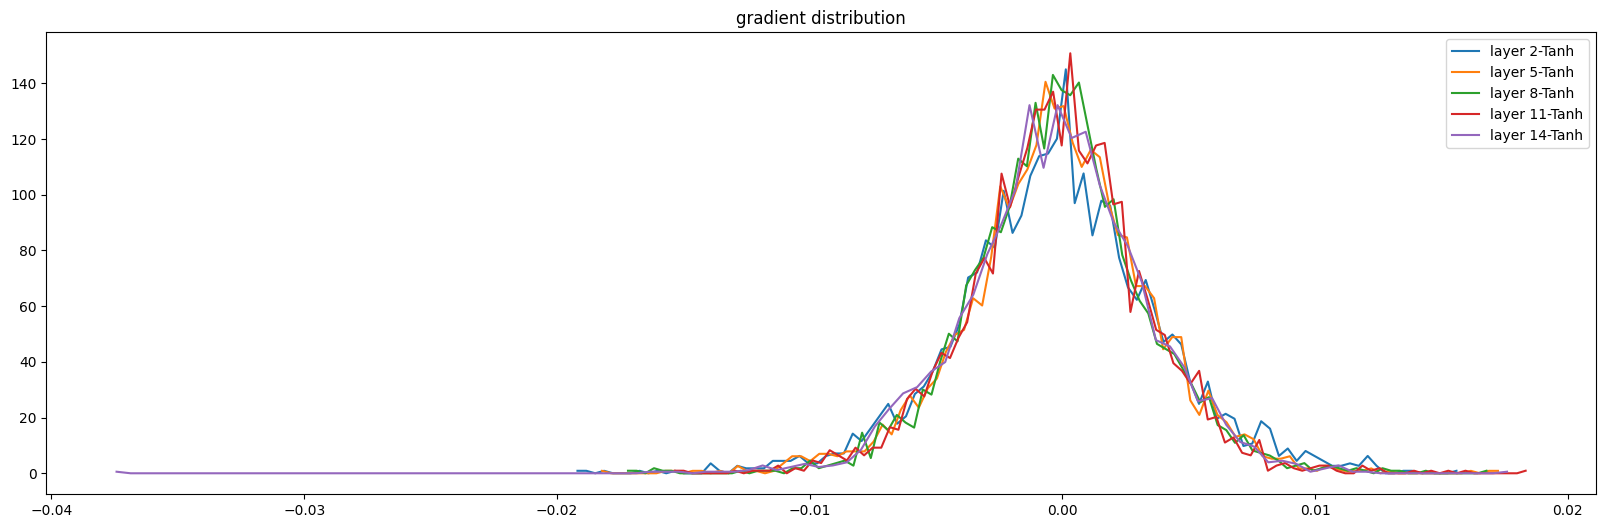

In [439]:
plt.figure(figsize=(20,6))
legend=[]
for i,layer in enumerate(layers):
    if isinstance(layer,Tanh):
            t=layer.out.grad
            print(f'layer {i}:{layer.__class__.__name__}, \t mean:{t.mean():.3f},\t std:{t.std():.3f}')
            hy,hx=torch.histogram(t,density=True)
            plt.plot(hx[:-1].detach(),hy.detach());
            legend.append(f'layer {i}-{layer.__class__.__name__}')
plt.legend(legend)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.509886e-03 | grad:data ratio 9.183791e-03
weight  (30, 100) | mean -0.000022 | std 2.633739e-03 | grad:data ratio 2.561731e-03
weight (100, 100) | mean +0.000019 | std 1.270741e-03 | grad:data ratio 1.273850e-03
weight (100, 100) | mean +0.000008 | std 1.156334e-03 | grad:data ratio 1.147197e-03
weight (100, 100) | mean -0.000012 | std 1.114283e-03 | grad:data ratio 1.110202e-03
weight (100, 100) | mean -0.000013 | std 1.095602e-03 | grad:data ratio 1.090635e-03
weight  (100, 27) | mean +0.000102 | std 2.337804e-03 | grad:data ratio 2.360402e-03


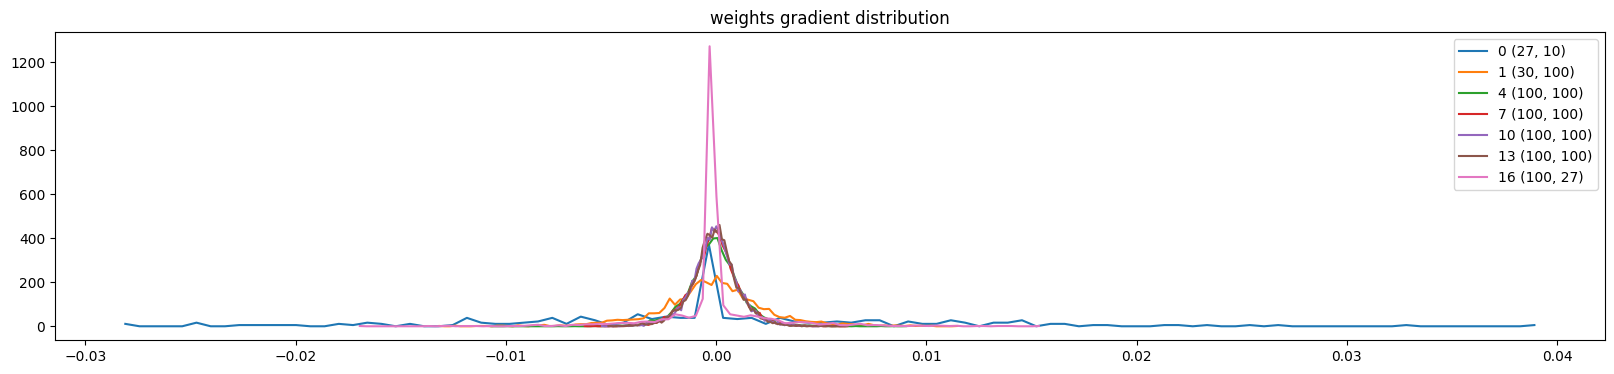

In [440]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

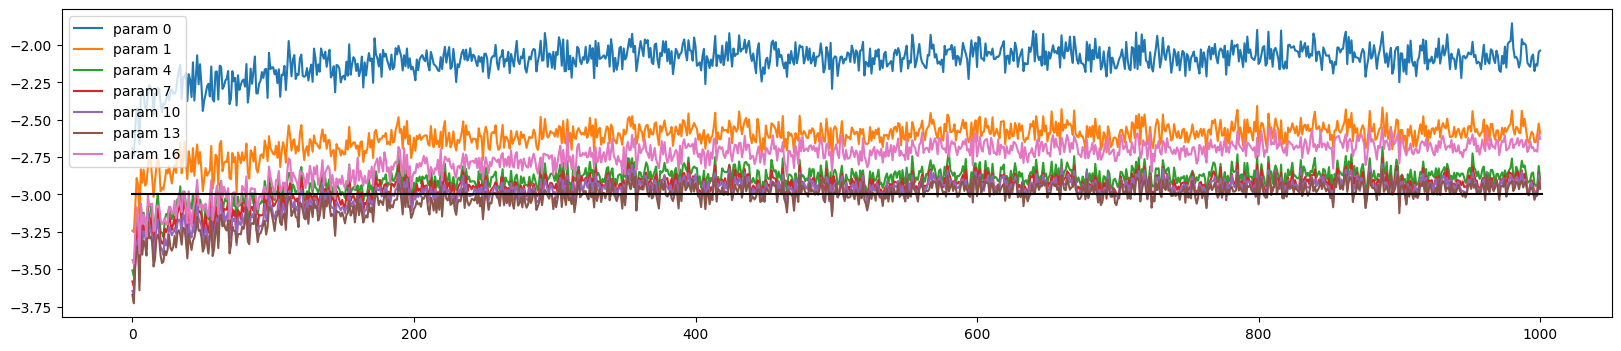

In [442]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([up[j][i] for j in range(len(up))])
    legends.append('param %d' % i)
plt.plot([0, len(up)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);